In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from fbprophet import Prophet
from urllib.request import urlopen
from zipfile import ZipFile
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Download and unzip zipfile
zipurl = 'https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/rossman_train.zip'
zipfile = urlopen(zipurl) 
tempfile = open("/tmp/tempfile.zip", "wb") # create temp zip file
tempfile.write(zipfile.read()) # write contents of the zipfile into tempfile
tempfile.close() # close temp zip file
zf = ZipFile("/tmp/tempfile.zip")
zf.extractall(path = '') # extract files from tempfile
zf.close()

In [3]:
# Load dataset
train_df = pd.read_csv("/content/rossman_train.csv")

# Open additional store data
file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/rossman_store.csv"
store_df = pd.read_csv(file_name)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
train_df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [ ]:
train_df.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_df.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [ ]:
store_df.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

In [ ]:
# Skew of Competition Distance
cd_skew = store_df.CompetitionDistance.skew()

if abs(cd_skew) > 1:
  print(f"Distribution is highly skewed. Skew {np.round(cd_skew, 4)}")
elif abs(cd_skew) > 0.5 and abs(cd_skew) <= 1:
  print(f"Distribution is moderately skewed. Skew {np.round(cd_skew, 4)}")
else:
  print(f"Distribution is fairly symmetrical. Skew {np.round(cd_skew, 4)}")

Distribution is highly skewed. Skew 2.9293


In [ ]:
# Fill Competition Distance with median values as it is highly skewed
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)

In [ ]:
# Check if Nan values of Promo2SinceWeek, Promo2SinceYear and PromoInterval are for the same rows
store_df[store_df.Promo2SinceWeek.isna()][['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].isna().all()

Promo2SinceWeek    True
Promo2SinceYear    True
PromoInterval      True
dtype: bool

In [ ]:
# Check if no promo is equal to no info in Promo2SinceWeek, Promo2SinceYear and PromoInterval columns
(store_df[store_df.Promo2SinceWeek.isna()].Promo2 == 0).all()

True

In [ ]:
# Fill Nan values with 0
store_df.fillna(0, inplace=True)

In [ ]:
# Convert Date into datetime type
train_df['Date'] = pd.to_datetime(train_df.Date)

# Set Date as index
train_df.set_index('Date', inplace=True)

In [ ]:
# Extract info from dates
train_df['year'] = train_df.index.year

train_df['month'] = train_df.index.month

train_df['week_of_year'] = train_df.index.weekofyear

train_df['sales_per_customer'] = train_df.Sales/train_df.Customers

In [ ]:
# quantiles functions
def q25(x):
  return x.quantile(0.25)

def q50(x):
  return x.quantile(0.5)

def q75(x):
  return x.quantile(0.75) 

def range(x):
  return x.max() - x.min()

In [ ]:
train_df[['Sales','Customers','sales_per_customer']].agg(['min',q25,q50,q75,'max','mean',range,'std','skew','kurt'])

,Sales,Customers,sales_per_customer
min,0.000000,0.000000,0.000000
q25,3727.000000,405.000000,7.895563
q50,5744.000000,609.000000,9.250000
q75,7856.000000,837.000000,10.899729
max,41551.000000,7388.000000,64.957854
mean,5773.818972,633.145946,9.493619
range,41551.000000,7388.000000,64.957854
std,3849.926175,464.411734,2.197494
skew,0.641460,1.598650,0.592160
kurt,1.778375,7.091773,2.759391


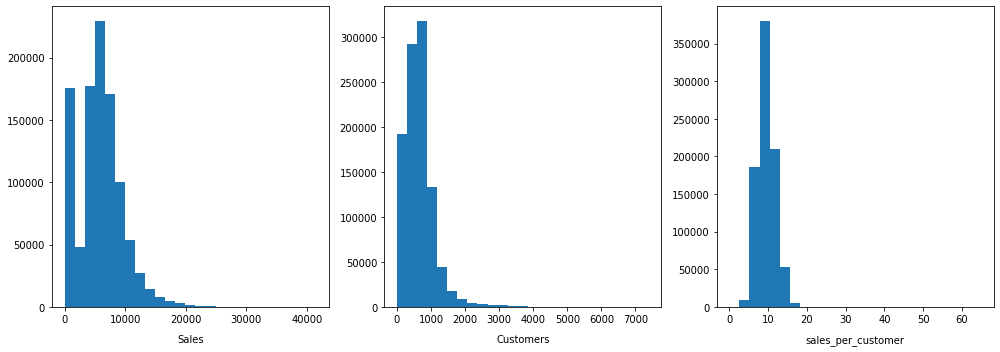

In [ ]:
plt.figure(figsize=(14,5))
for idx, col in enumerate(['Sales','Customers','sales_per_customer'], 1):
  plt.subplot(1, 3, idx)
  plt.xlabel(f'{col}', labelpad=10)
  plt.hist(train_df[f"{col}"], bins=25)
  plt.tight_layout()

In [ ]:
# Check how many open or closed stores there are in the dataset
f'There are {train_df.Open.value_counts()[0]} closed and {train_df.Open.value_counts()[1]} opened stores'

'There are 172817 closed and 844392 opened stores'

In [ ]:
# Do any open store have sales = 0 ?
(train_df[train_df.Open == 1].Sales == 0).any()

True

In [ ]:
# Leave only open stores in the dataset
train_df = train_df[train_df.Open == 1]

train_df.reset_index(inplace=True)

In [ ]:
# Merge dataframes (column-on-column operation) 
train_store_df = train_df.merge(store_df, on='Store', how='inner')

In [ ]:
train_store_df.groupby('StoreType').Sales.describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0


In [ ]:
train_store_df.groupby('StoreType')['Customers', 'Sales'].sum().rank(ascending=False)

,Customers,Sales
StoreType,,
a,1.0,1.0
b,4.0,4.0
c,3.0,3.0
d,2.0,2.0


Store A has the most sales and customers among all stores types. However, store B has the highest average sale because there is few data of it's type.

In [ ]:
train_store_df.groupby(['StoreType','Promo','DayOfWeek']).count().iloc[:,0]

StoreType  Promo  DayOfWeek
a          0      1            32695
                  2            36245
                  3            35613
                  4            32768
                  5            36021
                  6            78114
                  7             1100
           1      1            41908
                  2            41866
                  3            41380
                  4            40258
                  5            39109
b          0      1             1025
                  2             1041
                  3             1041
                  4             1043
                  5             1042
                  6             2215
                  7             2216
           1      1             1190
                  2             1187
                  3             1187
                  4             1187
                  5             1189
c          0      1             8084
                  2             8974
          

* Store C doesn't work on Sundays. Therefore, all data on Sundays are from store a, b, d.
* Promo is only during the week.

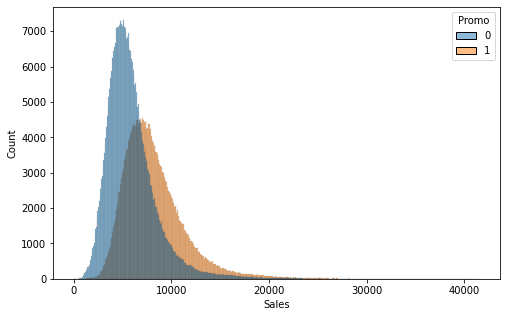

In [ ]:
# Are there are differences on the distribution of sales by promo? 
plt.figure(figsize=(8,5))
sns.histplot(data=train_store_df, x='Sales', hue='Promo')

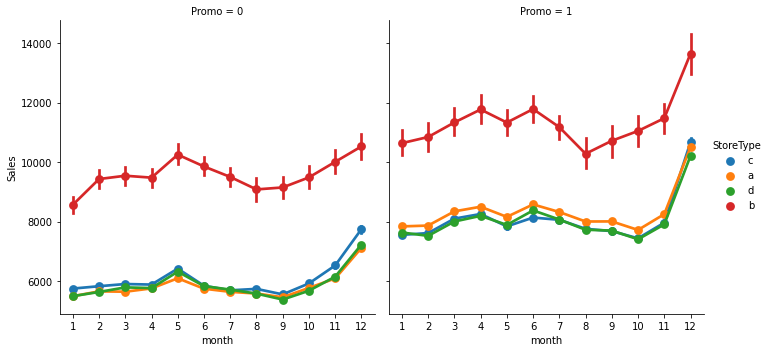

In [ ]:
sns.factorplot(data=train_store_df, x='month', y='Sales', col='Promo', hue='StoreType')

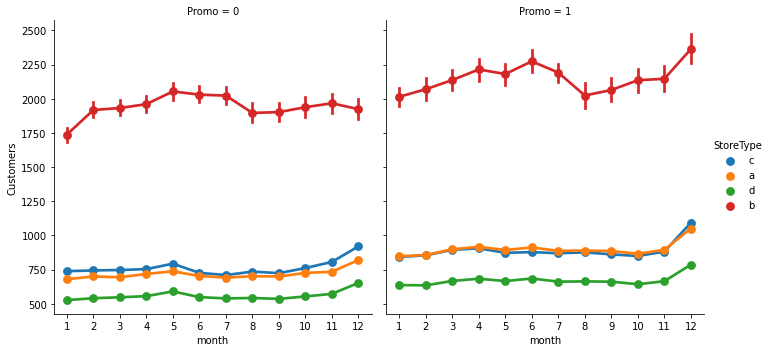

In [ ]:
sns.factorplot(data=train_store_df, x='month', y='Customers', col='Promo', hue='StoreType')

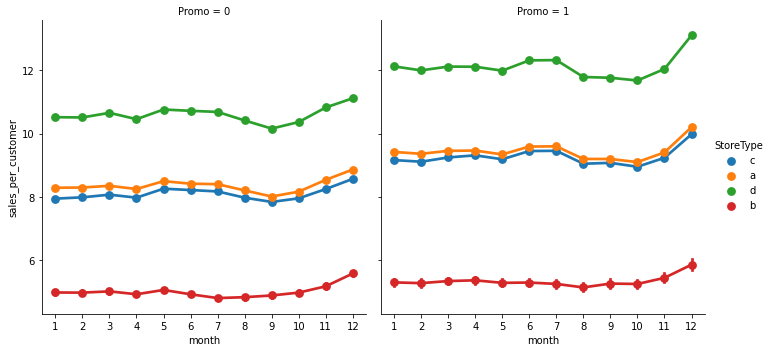

In [ ]:
sns.factorplot(data=train_store_df, x='month', y='sales_per_customer', col='Promo', hue='StoreType')

At first glance we see that sales are higher when there is a Promo in all type of stores.

StoreType B seems to outperform the rest of the stores on Sales and Customers. But when it comes to sales per customer, it isn't true since it is the store with the lowest sale per customer among all. This tell us that there are many customers in store b who buy low-value products.

The best perfoming store in terms of sales per customer is store d for the entire period examined. Then follows store a and c.

Sales, customers and sales per customer increase for all stores when there is Promo.

During the last months of the year sales tends to increase, as if it had a seasonal effect.

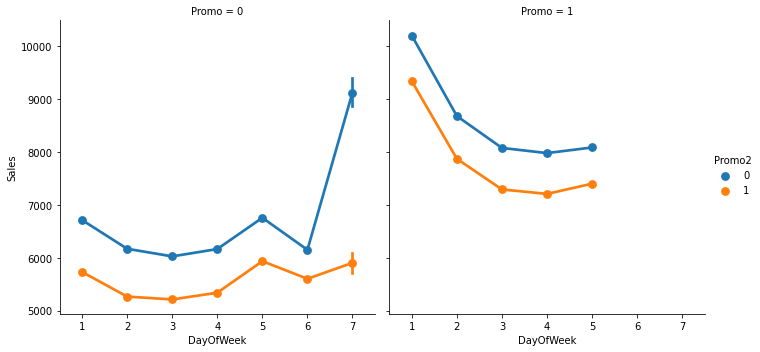

In [ ]:
sns.factorplot(data=train_store_df, x='DayOfWeek', y='Sales', col='Promo', hue='Promo2')

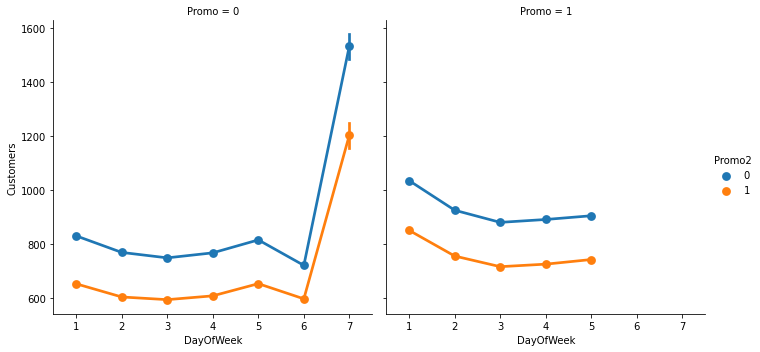

In [ ]:
sns.factorplot(data=train_store_df, x='DayOfWeek', y='Customers', col='Promo', hue='Promo2')

* When there is no promo, neither 1 or 2, sales tend to increase by far on Sundays.
* When Promo2 is on the run, whether Promo is on or not, sales decrease.
* Again, the best performing sale day when there is Promo for stores is on Monday.
* There is a big spike of customers when it is Sunday and Promo = 0, whether Promo2 is on or not. When Promo = 1, stores have more customers on Monday.

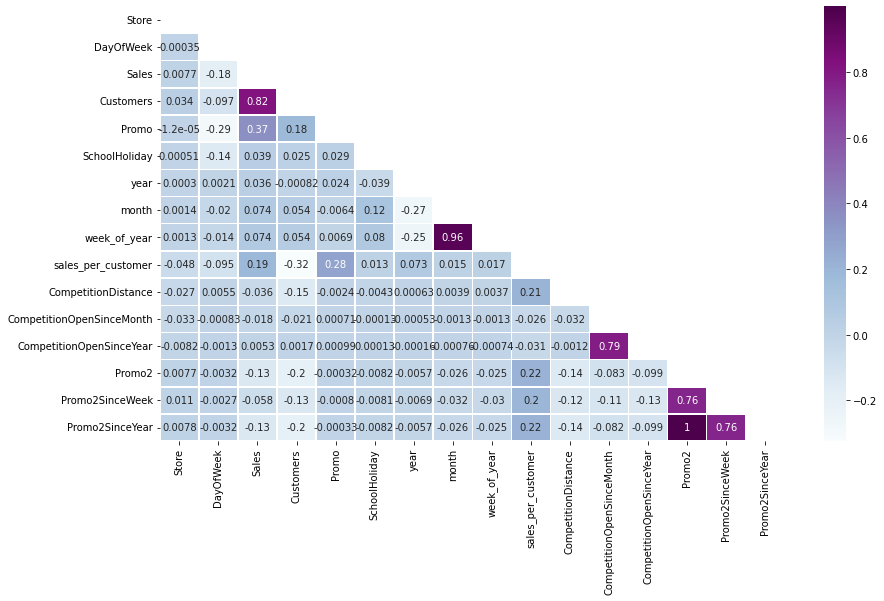

In [ ]:
corr = train_store_df.drop('Open', axis=1).corr()
matrix = np.triu(corr)

plt.figure(figsize=(14,8))
sns.heatmap(corr, mask=matrix, cmap="BuPu", linewidths=.5, annot=True)

* Numbers of customers has a strong positive correlation with sales.
* Promo (when it is running the value is equal to 1) has a positive correlation with sales and number of customers, and a negative correlation with the day of the week.
* Promo2 (when it is running the value is equal to 1) has a negative correlation with sales and number of customers.
* The presence of Promo on a store is negatively correlated with the day of the week.

### Time Series Analysis per Store Type

In [ ]:
train_store_df.set_index('Date', inplace=True)

In [ ]:
# Seed cell for reproducibility purposes
random.seed(94)

# List with stores within each type of store
stores_a = train_store_df[train_store_df.StoreType == 'a'].Store.unique().tolist()
stores_b = train_store_df[train_store_df.StoreType == 'b'].Store.unique().tolist()
stores_c = train_store_df[train_store_df.StoreType == 'c'].Store.unique().tolist()
stores_d = train_store_df[train_store_df.StoreType == 'd'].Store.unique().tolist()

# Select random store to represent its type
store_a = random.choice(stores_a)
store_b = random.choice(stores_b)
store_c = random.choice(stores_c)
store_d = random.choice(stores_d)

# Dataframe with sales of each store 
store_a_df = train_store_df[train_store_df.Store.isin([store_a])].Sales.astype(float).sort_index()
store_b_df = train_store_df[train_store_df.Store.isin([store_b])].Sales.astype(float).sort_index()
store_c_df = train_store_df[train_store_df.Store.isin([store_c])].Sales.astype(float).sort_index()
store_d_df = train_store_df[train_store_df.Store.isin([store_d])].Sales.astype(float).sort_index()

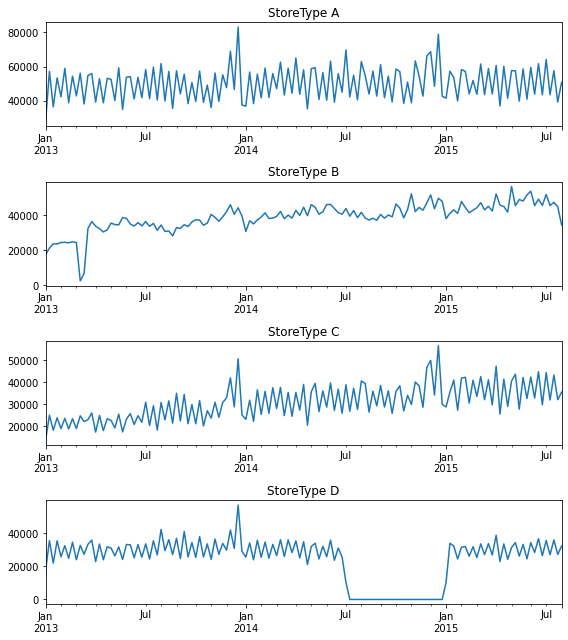

In [ ]:
# Plot time series of each store

fig, ax = plt.subplots(4, figsize=(8,9))

store_a_df.resample('W').sum().plot(ax = ax[0])
store_b_df.resample('W').sum().plot(ax = ax[1])
store_c_df.resample('W').sum().plot(ax = ax[2])
store_d_df.resample('W').sum().plot(ax = ax[3])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[0].set_title('StoreType A')
ax[1].set_title('StoreType B')
ax[2].set_title('StoreType C')
ax[3].set_title('StoreType D')

plt.tight_layout()

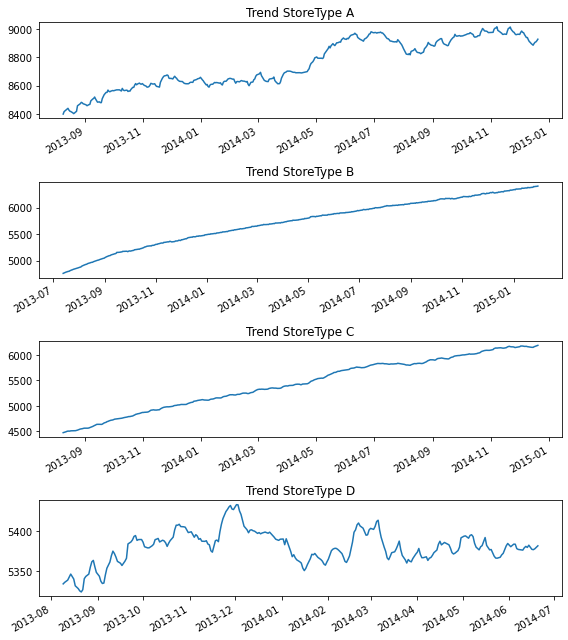

In [ ]:
# Stores sales trends
fig, ax = plt.subplots(4, figsize=(8,9))

store_a_decomp = seasonal_decompose(store_a_df, freq=365)
store_a_decomp.trend.plot(ax=ax[0])

store_b_decomp = seasonal_decompose(store_b_df, freq=365)
store_b_decomp.trend.plot(ax=ax[1])

store_c_decomp = seasonal_decompose(store_c_df, freq=365)
store_c_decomp.trend.plot(ax=ax[2])

store_d_decomp = seasonal_decompose(store_d_df, freq=365)
store_d_decomp.trend.plot(ax=ax[3])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[0].set_title('Trend StoreType A')
ax[1].set_title('Trend StoreType B')
ax[2].set_title('Trend StoreType C')
ax[3].set_title('Trend StoreType D')

plt.tight_layout()

All stores seems to be in an uptrend with exception store type D...

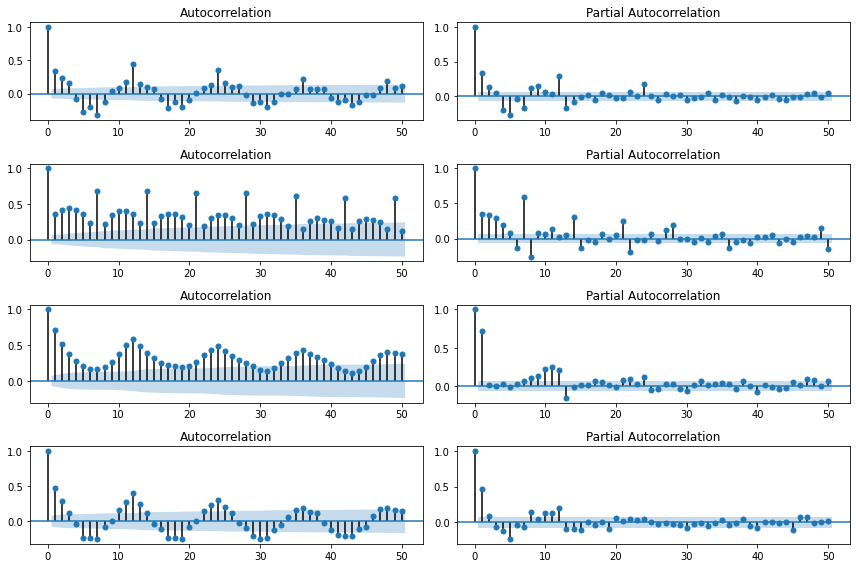

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8))

# acf and pacf for A
plot_acf(store_a_df, lags = 50, ax=ax[0,0])
plot_pacf(store_a_df, lags = 50, ax=ax[0,1])

# acf and pacf for B
plot_acf(store_b_df, lags = 50, ax=ax[1,0])
plot_pacf(store_b_df, lags = 50, ax=ax[1,1])

# acf and pacf for C
plot_acf(store_c_df, lags = 50, ax=ax[2,0])
plot_pacf(store_c_df, lags = 50, ax=ax[2,1] )

# acf and pacf for D
plot_acf(store_d_df, lags = 50, ax=ax[3,0])
plot_pacf(store_d_df, lags = 50, ax=ax[3,1])

plt.tight_layout()
plt.show()

It can be seen...

### Time series analysis & forecasting with Prophet

In [ ]:
# Prepare dataframe to use as an input in Prophet model
# We'll use store a
store_a_ph_df =  store_a_df.reset_index().rename({'Date':'ds', 'Sales':'y'}, axis=1)

In [ ]:
# Take into account Holidays when modeling
store_a_stateholidays = sorted(train_store_df[train_store_df.StateHoliday == 'a'].index.unique())
store_a_schoolholidays = sorted(train_store_df[(train_store_df.StoreType == 'a') & (train_store_df.SchoolHoliday == 1)].index.unique())

store_a_stateholidays_df = pd.DataFrame({'holiday':'state_holiday','ds':store_a_stateholidays})
store_a_schoolholidays_df = pd.DataFrame({'holiday':'school_holiday','ds':store_a_schoolholidays})

holidays = pd.concat([store_a_stateholidays_df, store_a_schoolholidays_df])
holidays = holidays[~holidays.ds.duplicated()]

In [ ]:
%%time 
# set the uncertainty interval to 95%
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)

my_model.fit(store_a_ph_df)

# dataframe that extends into future month by day 
future_dates = my_model.make_future_dataframe(periods = 4*7)

forecast = my_model.predict(future_dates)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 3.96 s, sys: 2.56 s, total: 6.52 s
Wall time: 3.8 s


* Black dots are observed values, the blue line are the forecasted values and the light blue shaded regions are the confidence intervals of the forecasts.

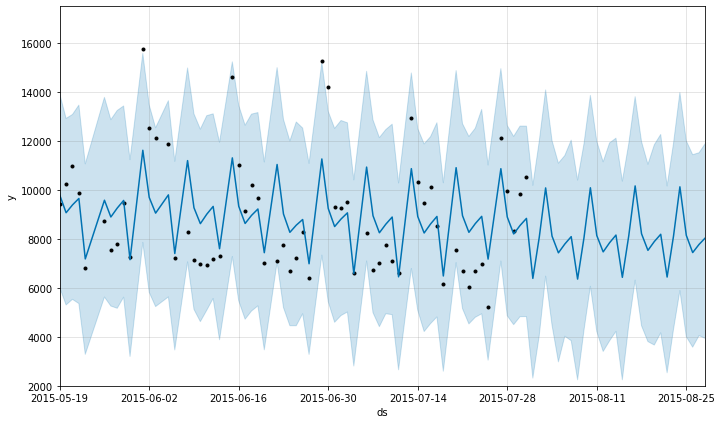

In [ ]:
# Forecast of the model with confidence intervals
my_model.plot(forecast)
plt.xlim(forecast.iloc[-90:].ds.iloc[0], forecast.iloc[-60:].ds.iloc[-1])
plt.ylim(2000, 17500)
plt.show()

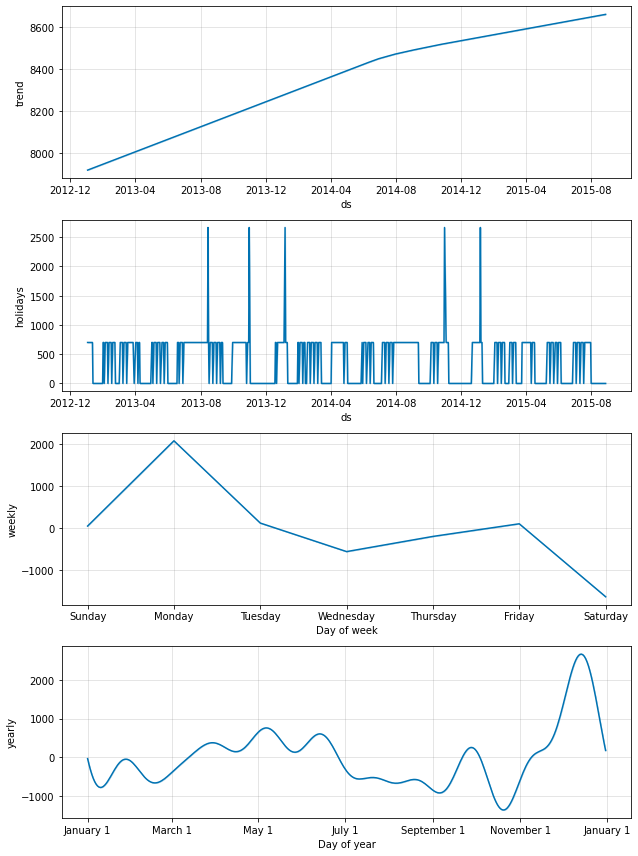

In [ ]:
# Trend, holidays, and weekly and yearly seasonality of the store
my_model.plot_components(forecast)
plt.show()

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays